# Exploration 16. 다음에 볼 영화 예측하기

## 프로젝트_Movielens 영화 SBR
* ```Movielens 1M Dataset```을 기반으로, ```Session based Recommendation``` 시스템을 제작
* 해당 데이터셋에서는 ```UserID```가 ```SessionID``` 역할을 수행
* ```Rating``` 정보의 가공 필요
  * 직전에 봤던 영화가 마음에 들었는지 여부가 비슷한 영화를 고르는 것과 연관이 있을 수 있음
  * ```Rating```이 낮은 데이터를 어떻게 처리할지도 고려 필요
* ```Time``` 항목에는 ```UTC time```이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있음

## 루브릭 평가 기준
|평가문항|평가문항|
|:-----|:-----|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

## Session based Recommendation
* 유저들이 선택했던 아이템 순서를 고려해 학습한 추천 모델
* 모델에 적용될 학습데이터는 각각 유저들이 일정 기간 동안 선택했던 아이템들을 순서대로 제공되어야 하며, 모델은 이러한 순서로 들어오는 데이터들을 받고 학습
* 고려해야 할 사항
  1. 학습 로그들을 실시간으로 처리하고 지속적으로 모델을 학습시킬 수 있어야 함
  2. 지속적으로 학습되는 모델을 이용해서 빠르게 추천 결과들을 서비스에 제공 할 수 있어야 함
  3. 각각의 단계에서의 컴퓨팅 자원을 효과적으로 사용하고 관리할 수 있어야 함

## Step 1. 데이터의 전처리
* 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행
* 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의

In [48]:
# Pandas와 Tensorflow의 라이브러리 버전 확인

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
import pandas
import tensorflow
import time
from datetime import datetime

warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


* Cloud Shell을 이용한 실습 디렉토리 구성
  1. 데이터 확인<br>
     ```$ ls -l ~/data```<br>
  2. 프로젝트 폴더 생성<br>
     ```$ mkdir -p ~/aiffel/yoochoose```<br>
  3. 프로젝트 폴더로 데이터 폴더 링크 연결<br>
     ```$ ln -s ~/data/* ~/aiffel/yoochoose/data```<br>

In [49]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [50]:
# 데이터프레임의 타입 확인
data.dtypes

UserId    int32
ItemId    int32
Rating    int32
Time      int64
dtype: object

In [51]:
# Time 컬럼의 자료형 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [52]:
# 유저 수(세션 수)와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [53]:
# 각 세션이 대략 몇 개의 클릭 데이터를 가지는지 확인
# session_length : UserId를 공유하는 데이터 row의 개수
# UserId : 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
# 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 
# 최소한 특정 사용자의 행동을 UserId 기준으로 모아서 분류 가능
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [54]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

각 세션의 길이는 보통 96에서 165 정도이다.

In [55]:
session_length.min(), session_length.max()

(20, 2314)

최소 세션 길이는 20이며, 최대 세션 길이는 2314이다.

In [56]:
session_length.quantile(0.99)

906.659999999998

99.9% 세션은 길이가 약 906 이하이다.

In [57]:
# 최대 길이를 가진 UserId의 정보를 확인한다.
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


2000년 8월 3일부터 2002년 6월 15일까지 2년 여 동안 지속적으로 이용한 것을 확인할 수 있다.

In [58]:
# 세션 길이 기준 하위 99%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

In [59]:
length_percent_cumsum_99.min(), length_percent_cumsum_99.max()

(0.01423841059602649, 0.9899006622516556)

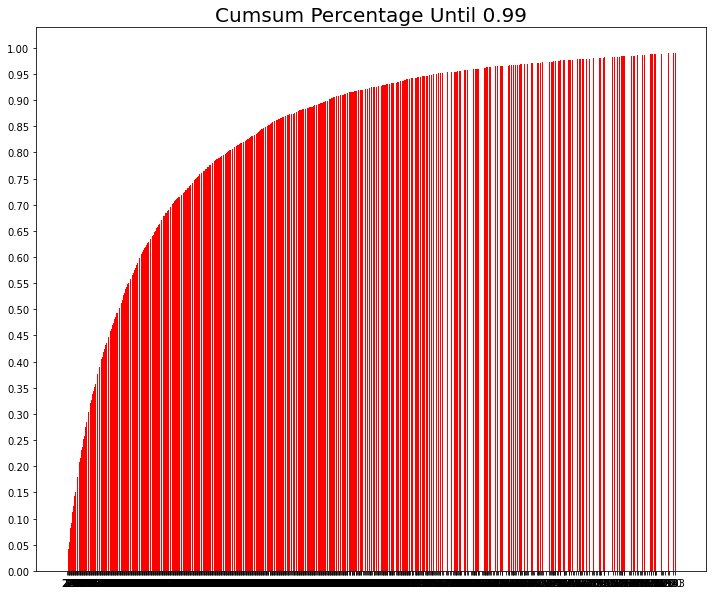

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

In [62]:
# 데이터의 시간 관련 정보 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


총 3년치의 데이터가 존재하며, 최근 1년치의 데이터를 사용하려고 한다.

In [63]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [64]:
# 날짜끼리의 차이를 구하기 위하여 datetime 라이브러리의 timedelta 객체를 사용
# year_ago = latest - dt.timedelta(365)  # 최종 날짜로부터 1년 이전 날짜를 구한다.  
# data = data[data['Time'] > year_ago]  # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

초반에는 1년치의 데이터만 추출해서 사용하려 하였으나, 데이터가 적어 결과값이 제대로 나오지 않아 3년치의 데이터를 그대로 사용

In [65]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_view):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_view].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [66]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


user는 평균 165번의 영화를 시청했으며, item(영화)는 평균 269번 시청되었음을 알 수 있다.

In [67]:
# 1번만 시청된 영화와 5번 이하 시청한 user의 데이터를 제거
data = cleanse_recursive(data, shortest=5, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [68]:
# 데이터를 시간 순으로 정렬
data = data.sort_values(by=['Time'])
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
825793,4958,2399,1,2003-02-28 17:45:38
825438,4958,1407,5,2003-02-28 17:47:23
825724,4958,3264,4,2003-02-28 17:49:08
825731,4958,2634,3,2003-02-28 17:49:08


In [69]:
# Train / Valid / Test split

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)]
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)]

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [70]:
# 3년치 데이터 중에서 3개월은 valid 데이터로, 마지막 3개월은 test 데이터로 사용
tr, test = split_by_date(data, n_days = 90)
tr, val = split_by_date(tr, n_days = 90)

In [79]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [80]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 860659
	 Users: 5701
	 Items: 3588
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 00:14:13

* valid Set Stats Info
	 Events: 41681
	 Users: 106
	 Items: 3046
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 97747
	 Users: 233
	 Items: 3322
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [81]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [82]:
# 전처리가 끝난 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
* 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성
* Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
* 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있음

In [83]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 SessionDataset 클래스 생성

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [84]:
# train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 확인
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999920,6040,213,5,2000-04-25 23:07:36,9


In [85]:
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있음
tr_dataset.click_offsets

array([     0,     53,    182, ..., 860195, 860318, 860659], dtype=int32)

In [86]:
# session_idx 변수는 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([   0,    1,    2, ..., 5698, 5699, 5700])

In [87]:
# SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 SessionDataLoader 클래스 생성

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [88]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head

<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
1000138    6040     858       4 2000-04-25 23:05:32         0
999873     6040     593       5 2000-04-25 23:05:54         1
1000153    6040    2384       4 2000-04-25 23:05:54         2
1000007    6040    1961       4 2000-04-25 23:06:17         3
1000192    6040    2019       5 2000-04-25 23:06:17         4
...         ...     ...     ...                 ...       ...
973442     5872    3826       3 2002-08-30 00:01:21      3335
502949     3087    1584       1 2002-08-31 20:30:52       412
503054     3087    1092       4 2002-08-31 20:38:06      1373
502866     3087    1892       4 2002-08-31 20:38:06      1634
22789       164    3916       5 2002-09-01 00:14:13      3474

[860659 rows x 5 columns]>

In [89]:
iter_ex = iter(tr_data_loader)

In [90]:
# input, output, mask의 대략적인 형태 확인
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


## Step 3. 모델 구성
* 다양한 모델 구조 시도

In [91]:
# Evaluation Metric : 모델 성능 평가를 위한 지표 확인

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [92]:
# Model Architecture
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [93]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [94]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr  # learning rate
        self.epochs = epochs
        self.k = k

## Step 4. 모델 학습
* 다양한 하이퍼파라미터를 변경해 보며 검증
* 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 함

In [96]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING') # softmax 값이 큰 순서대로 sorting 합니다.
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [97]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 4-1. 1차 모델 학습
* batch_size = 64
* hsz = 50
* drop_rate = 0.1
* lr = 0.001

In [99]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3588)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      546000    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3588)                182988    
Total params: 728,988
Trainable params: 728,988
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:43<01:28,  3.38it/s]


	 - Recall@20 epoch 1: 0.194196
	 - MRR@20    epoch 1: 0.044809



Evaluation:  54%|█████▍    | 350/649 [01:41<01:26,  3.45it/s]


	 - Recall@20 epoch 2: 0.240759
	 - MRR@20    epoch 2: 0.055660



Evaluation:  54%|█████▍    | 350/649 [01:39<01:24,  3.52it/s]


	 - Recall@20 epoch 3: 0.252455
	 - MRR@20    epoch 3: 0.060145



Evaluation:  54%|█████▍    | 350/649 [01:39<01:25,  3.52it/s]


	 - Recall@20 epoch 4: 0.258661
	 - MRR@20    epoch 4: 0.063279



Evaluation:  54%|█████▍    | 350/649 [01:39<01:24,  3.52it/s]

	 - Recall@20 epoch 5: 0.258259
	 - MRR@20    epoch 5: 0.064709



### 4-2. 2차 모델 학습
* batch_size = 64
* hsz = 50
* drop_rate = 0.05
* lr = 0.001

In [101]:
args2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.05, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3588)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      546000    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3588)                182988    
Total params: 728,988
Trainable params: 728,988
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:43<01:28,  3.38it/s]


	 - Recall@20 epoch 1: 0.194821
	 - MRR@20    epoch 1: 0.044169



Evaluation:  54%|█████▍    | 350/649 [01:40<01:25,  3.49it/s]


	 - Recall@20 epoch 2: 0.238393
	 - MRR@20    epoch 2: 0.055560



Evaluation:  54%|█████▍    | 350/649 [01:40<01:25,  3.50it/s]


	 - Recall@20 epoch 3: 0.254643
	 - MRR@20    epoch 3: 0.059571



Evaluation:  54%|█████▍    | 350/649 [01:39<01:24,  3.52it/s]


	 - Recall@20 epoch 4: 0.259062
	 - MRR@20    epoch 4: 0.061965



Evaluation:  54%|█████▍    | 350/649 [01:39<01:24,  3.53it/s]

	 - Recall@20 epoch 5: 0.258929
	 - MRR@20    epoch 5: 0.063474



### 4-3. 3차 모델 학습
* batch_size = 64
* hsz = 50
* drop_rate = 0.5
* lr = 0.001

In [103]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3588)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      546000    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3588)                182988    
Total params: 728,988
Trainable params: 728,988
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:44<01:29,  3.34it/s]


	 - Recall@20 epoch 1: 0.162500
	 - MRR@20    epoch 1: 0.037509



Evaluation:  54%|█████▍    | 350/649 [01:42<01:27,  3.42it/s]


	 - Recall@20 epoch 2: 0.221071
	 - MRR@20    epoch 2: 0.052388



Evaluation:  54%|█████▍    | 350/649 [01:41<01:26,  3.46it/s]


	 - Recall@20 epoch 3: 0.237857
	 - MRR@20    epoch 3: 0.056709



Evaluation:  54%|█████▍    | 350/649 [01:40<01:25,  3.48it/s]


	 - Recall@20 epoch 4: 0.245491
	 - MRR@20    epoch 4: 0.058280



Evaluation:  54%|█████▍    | 350/649 [01:40<01:25,  3.49it/s]

	 - Recall@20 epoch 5: 0.250580
	 - MRR@20    epoch 5: 0.059968



### 4-4. 4차 모델 학습
* batch_size = 128
* hsz = 50
* drop_rate = 0.1
* lr = 0.001

In [105]:
args4 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3588)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    546000    
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 3588)               182988    
Total params: 728,988
Trainable params: 728,988
Non-trainable params: 0
_________________________________________________________________


Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]


IndexError: index 106 is out of bounds for axis 0 with size 106

배치 사이즈를 늘리게 되니 배열의 범위를 벗어났다는 오류가 발생함을 확인했다.

### 4-5. 5차 모델 학습
* batch_size = 32
* hsz = 50
* drop_rate = 0.1
* lr = 0.001

In [106]:
args5 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model5 = create_model(args5)
train_model(model5, args5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 1, 3588)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      546000    
_________________________________________________________________
dropout_6 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (32, 3588)                182988    
Total params: 728,988
Trainable params: 728,988
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1299 [02:39<00:47,  6.28it/s]


	 - Recall@20 epoch 1: 0.213933
	 - MRR@20    epoch 1: 0.048864



Evaluation:  77%|███████▋  | 999/1299 [02:34<00:46,  6.48it/s]


	 - Recall@20 epoch 2: 0.240209
	 - MRR@20    epoch 2: 0.057475



Evaluation:  77%|███████▋  | 999/1299 [02:33<00:46,  6.49it/s]


	 - Recall@20 epoch 3: 0.251908
	 - MRR@20    epoch 3: 0.060518



Evaluation:  77%|███████▋  | 999/1299 [02:33<00:46,  6.51it/s]


	 - Recall@20 epoch 4: 0.254442
	 - MRR@20    epoch 4: 0.062442



Evaluation:  77%|███████▋  | 999/1299 [02:33<00:46,  6.52it/s]

	 - Recall@20 epoch 5: 0.255599
	 - MRR@20    epoch 5: 0.063575



## Step 5. 모델 테스트
* 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인

### 5-1. 1차 모델 테스트
* batch_size = 64
* hsz = 50
* drop_rate = 0.1
* lr = 0.001

In [100]:
test_model(model, args, test)

Evaluation:  80%|███████▉  | 1218/1523 [05:49<01:27,  3.48it/s]

	 - Recall@20: 0.234490
	 - MRR@20: 0.057299



### 5-2. 2차 모델 테스트
* batch_size = 64
* hsz = 50
* drop_rate = 0.05
* lr = 0.001

In [102]:
test_model(model2, args2, test)

Evaluation:  80%|███████▉  | 1218/1523 [05:49<01:27,  3.48it/s]

	 - Recall@20: 0.233759
	 - MRR@20: 0.056788



### 5-3. 3차 모델 테스트
* batch_size = 64
* hsz = 50
* drop_rate = 0.5
* lr = 0.001

In [104]:
test_model(model3, args3, test)

Evaluation:  80%|███████▉  | 1218/1523 [05:51<01:28,  3.46it/s]

	 - Recall@20: 0.226935
	 - MRR@20: 0.053127



### 5-4. 4차 모델 테스트
* batch_size = 128
* hsz = 50
* drop_rate = 0.1
* lr = 0.001<br>
학습 과정에서 발생한 인덱스 오류로 인하여 테스트 진행이 불가능하였다.

### 5-5. 5차 모델 테스트
* batch_size = 32
* hsz = 50
* drop_rate = 0.1
* lr = 0.001

In [107]:
test_model(model5, args5, test)

Evaluation:  90%|█████████ | 2757/3047 [07:13<00:45,  6.36it/s]

	 - Recall@20: 0.220484
	 - MRR@20: 0.054498



배치 사이즈를 줄였을 때 성능이 향상되는 것을 확인할 수 있다.

## 회고
* 배치 사이즈를 64 이상으로 늘리면 인덱스의 범위를 벗어났다는 오류가 발생하는데, 왜 이런 오류가 발생했는지에 대한 정확한 원인을 찾지 못했다. 다만 나름의 추측으로는 검증 데이터와 테스트 데이터의 비율을 적게 잡아서가 아닐까 생각한다.

## 참고 링크
* [[기고] 홈쇼핑모아에서 만드는 AI 기반 상품 추천 시스템](https://www.comworld.co.kr/news/articleView.html?idxno=50160)
* [Pandas에서 숫자와 문자열을 datetime으로 변환하는 10가지 트릭](https://ichi.pro/ko/pandas-eseo-susjawa-munjayeol-eul-datetimeeulo-byeonhwanhaneun-10-gaji-teulig-143642570244669)
* [넘파이(Numpy) 튜토리얼](https://teddylee777.github.io/python/numpy-tutorial)